In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import functools
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import IPython.display

TensorFlow 1.x selected.


In [ ]:
# Enable Eager Execution
tf.enable_eager_execution()

In [ ]:
# The path to the content image
path_contentImg = '/content/drive/MyDrive/CV_temp/content_3.jpg'
# The path to the style image.
path_styleImg = '/content/drive/MyDrive/CV_temp/style_4.jpg'

In [ ]:
# Loading and resize the image 
def load_img(path):
  max_dim = 512
  img = Image.open(path)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  img = kp_image.img_to_array(img)
  # Broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

Text(0.5, 1.0, 'Content Image')

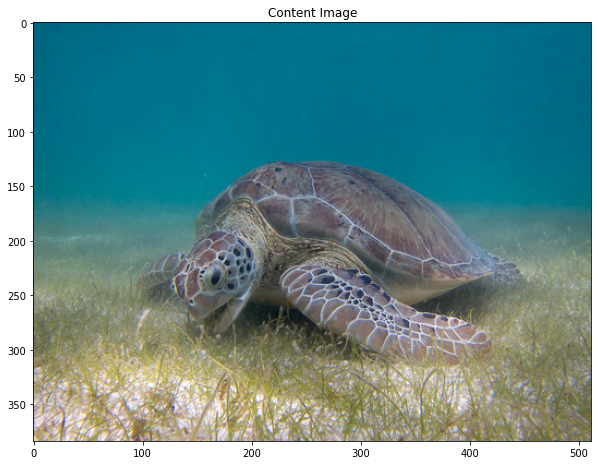

In [ ]:
plt.figure(figsize=(10,10))
content = load_img(path_contentImg).astype('uint8')
out = np.squeeze(content, axis=0)
# Normalize for display 
out = out.astype('uint8')
# Plot Content Image
plt.imshow(out)
plt.title('Content Image')

Text(0.5, 1.0, 'Style Image')

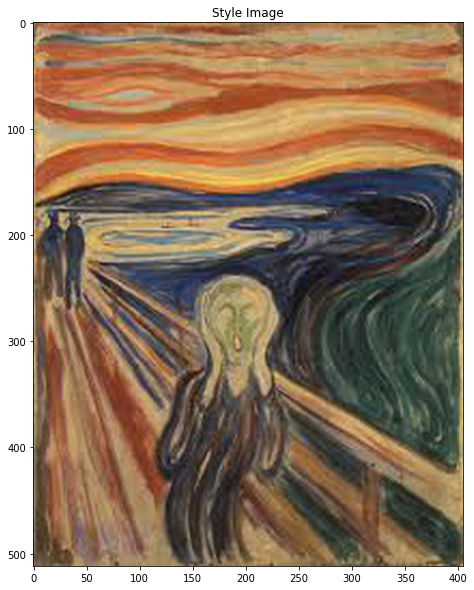

In [ ]:
style = load_img(path_styleImg).astype('uint8')
out = np.squeeze(style, axis=0)
# Normalize for display 
out = out.astype('uint8')
# Plot Style image
plt.imshow(out)
plt.title('Style Image')

In [ ]:
def load_and_process_img(path):
  img = load_img(path)
  img = tf.keras.applications.vgg16.preprocess_input(img)
  return img

In [ ]:
def deprocess_img(img):
  x = img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv1'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

n_content = len(content_layers)
n_style = len(style_layers)

In [ ]:
# Create Model
def get_model():
  # Load VGG16 model and access the itermediate layers
  vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # return a model that takes image inputs and outputs the style and content intermediate layers. 
  return models.Model(vgg.input, model_outputs)

In [ ]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [ ]:
def gram_matrix(input_tensor):
  # Make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  # the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  return tf.reduce_mean(tf.square(gram_style - gram_target)) 

In [ ]:
# Compute content and style feature representation
def get_feature_representations(model, path_contentImg, path_styleImg):
  # Load images 
  content_image = load_and_process_img(path_contentImg)
  style_image = load_and_process_img(path_styleImg)
  # compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image) 
  # Get the style and content feature representations  
  style_features = [style_layer[0] for style_layer in style_outputs[:n_style]]
  content_features = [content_layer[0] for content_layer in content_outputs[n_style:]]
  return style_features, content_features

In [ ]:
# Compute total Loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  # Feed init image through model
  model_outputs = model(init_image)
  style_output_features = model_outputs[:n_style]
  content_output_features = model_outputs[n_style:]
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  weight_per_style_layer = 1.0 / float(n_style)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(n_content)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight
  # Total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [ ]:
# Compute gradients with respect to input image
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [ ]:
def run_style_transfer(path_contentImg, path_styleImg, num_iterations=1000, content_weight=1e3, style_weight=1e-2): 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations  
  style_features, content_features = get_feature_representations(model, path_contentImg, path_styleImg)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  # Set initial image
  init_image = load_and_process_img(path_contentImg)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # Displaying intermediate images 
  iter_count = 1
  best_loss, best_img = float('inf'), None
  loss_weights = (style_weight, content_weight)

  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  imgs = []

  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 'style loss: {:.4e}, ' 'content loss: {:.4e}, ' 'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
          
  return best_img, best_loss 

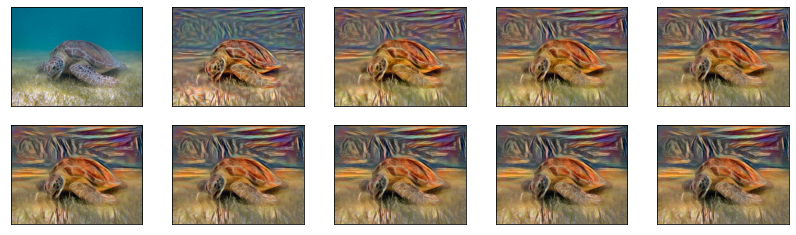

In [ ]:
best, best_loss = run_style_transfer(path_contentImg, path_styleImg, num_iterations=1000)

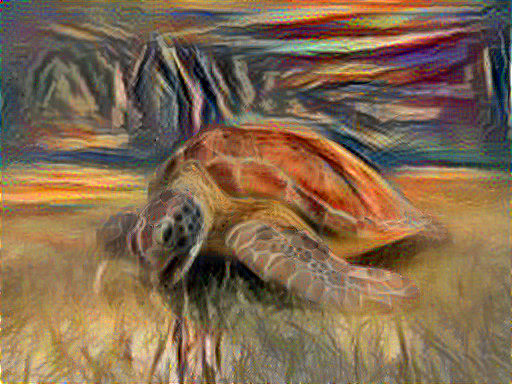

In [ ]:
Image.fromarray(best)

In [ ]:
'''The code above is referred from https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398'''